# 📘 Notebook: 04_LSTM_model.ipynb
_**Part of the Fragma IPython Notebook Project Series**_

*Focused on developing and evaluating LSTM models for fragment detection.*

---

## 🧭 Table of Contents

1. [📘 Overview & Navigation](#overview)
2. [🧠 Context & Purpose](#context)
3. [📦 Dependencies & Imports](#imports)
4. [🛠️ Config & Setup](#setup)
5. [📊 Data Loading & EDA](#eda)
6. [🧹 Data Preprocessing](#preprocessing)
7. [🔍 PSO Hyperparameter Optimization](#pso_optimization)
8. [🧠 LSTM Model Development](#model)
9. [📈 Model Evaluation](#evaluation)
10. [🔍 Error Analysis](#error_analysis)
11. [🚀 Pipeline & Inference](#pipeline)
12. [🏁 Conclusion](#conclusion)
13. [👥 Contributors](#team)

> **Quick Links:** [🏠 Home](#overview) | [🔄 Status](#model) | [📚 Docs](#evaluation)

---

## 🧪 Overview & Navigation {#overview}

This notebook builds an LSTM-based deep learning model for fragment detection, expanding on the previous Random Forest approach.
It provides: **A neural network approach to fragment detection using word embeddings and LSTM architecture for improved sequence understanding.**

---

## 🧠 Context & Purpose {#context}

**🎯 Purpose:**  
To develop a deep learning model that can accurately classify whether a sentence is a fragment or a complete sentence.

**🎯 Objectives:**  
- Process and prepare text data for deep learning
- Build an LSTM model for sequence classification
- Evaluate model performance against traditional approaches
- Analyze error patterns and model behavior
- Create a reusable pipeline for fragment detection

**📘 Context:**  
This notebook builds on the preprocessed data from notebook 02 and extends the modeling approach from notebook 03 by using deep learning techniques.

---

## 🧩 Main Components

### `LSTMModel`
> A bidirectional LSTM model for sequence classification with attention mechanism.

```python
model = Sequential([
    ....
])
```

## ⚙️ Model Architecture

### 1. Text Embedding Layer
- **Word Embedding**: Convert words to dense vectors
- **Vocabulary Size**: Up to 10,000 words
- **Embedding Dim**: 128 dimensions

### 2. LSTM Layers
- **Bidirectional LSTM**: Capture context from both directions
- **Units**: 64 LSTM units per direction
- **Return Sequences**: True for first layer

### 3. Regularization
- **Dropout**: 20% dropout between layers
- **Early Stopping**: Monitor validation loss
- **Model Checkpointing**: Save best weights

### 4. Output Layer
- **Dense Layer**: Single unit with sigmoid
- **Binary Classification**: Fragment vs Complete

### 5. Training Config
- **Loss**: Binary Cross-Entropy
- **Optimizer**: Adam with learning rate 0.001
- **Batch Size**: 32 samples
- **Epochs**: Up to 10 with early stopping

## 📦 Dependencies

```bash
tensorflow     # Deep learning framework
keras         # Neural network API
pandas        # Data manipulation
numpy         # Numerical operations
scikit-learn # Metrics and evaluation
matplotlib   # Plotting
seaborn      # Enhanced visualization
colab_print  # For Pretty Printing
```

### Key TensorFlow Components:
```python
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers: Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks: EarlyStopping, ModelCheckpoint
```

## 🛠️ Configuration Setup

The following configuration cells set up the required environment and parameters for our LSTM model. We'll cover:

1. Workspace Setup
2. Project Constants
3. Model Parameters
4. Data Processing Settings


### Part 1: Core Dependencies
First, let's install and import the required libraries:

In [16]:
!pip install kagglehub pandas numpy tqdm matplotlib seaborn scikit-learn
!pip install -U colab_print # Always use last version

### Part 2: Library Imports
Now we'll import all necessary libraries and modules:

In [17]:
import os
import pandas as pd
import subprocess
import argparse
import random
from colab_print import Printer, header, list_, table, dfd, info, error, success, warning, title
from typing import Tuple, List, Dict, Optional, Union
from tqdm.auto import tqdm
import shutil
from typing import List, Optional, Dict, Tuple, Any, Union, Literal
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score,train_test_split

## ⚙️ Model Configuration

### Dataset Configuration
```python
URL = "tomthescientist/netflix-facebook-posts-as-sentences-for-llm-input"
FILENAME = "netflix_fb_sentences.csv"
FDPATH = 'dataset_fragments.csv'
EXPANDPATH = 'expanded_dataset.csv'
PROCESSEDPATH = 'processed_dataset.csv'
```

### LSTM Model Configuration
```python
MAX_WORDS = 10000           # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 100   # Maximum sequence length
TEST_SIZE = 0.2            # Test split ratio
VALIDATION_SIZE = 0.1      # Validation split ratio
RANDOM_STATE = 42          # Random seed
```

### Model Hyperparameters
```python
DEFAULT_EMBEDDING_DIM = 128  # Word embedding dimension
DEFAULT_LSTM_UNITS = 64     # LSTM units per direction
DEFAULT_DROPOUT_RATE = 0.2  # Dropout probability
DEFAULT_LEARNING_RATE = 0.001  # Adam learning rate
DEFAULT_BATCH_SIZE = 32     # Training batch size
DEFAULT_EPOCHS = 10         # Maximum training epochs
```

### Early Stopping Settings
```python
PATIENCE = 3              # Early stopping patience
MONITOR_METRIC = 'val_loss'  # Metric to monitor
```

### PSO Optimization Settings
```python
PSO_PARTICLES = 10        # Number of particles
PSO_ITERATIONS = 15       # Number of iterations
PSO_INERTIA_WEIGHT = 0.5  # Inertia weight
PSO_COGNITIVE_COEFF = 1.5  # Cognitive coefficient
PSO_SOCIAL_COEFF = 1.5    # Social coefficient
```

### PSO Parameter Bounds
```python
PSO_EMBEDDING_DIM_BOUNDS = (64, 256)     # Embedding dimension range
PSO_LSTM_UNITS_BOUNDS = (32, 128)       # LSTM units range
PSO_DROPOUT_RATE_BOUNDS = (0.1, 0.5)    # Dropout rate range
PSO_LEARNING_RATE_LOG_BOUNDS = (-4, -2) # Learning rate range (log scale)
PSO_BATCH_SIZE_BOUNDS = (16, 64)        # Batch size range
```

In [18]:
def download_ds(url):
  import kagglehub

  # Download latest version
  path = kagglehub.dataset_download(url)

  print("Path to dataset files:", path)
  return path

def mount_drive():
  from google.colab import drive
  """Uploads the dataset_fragments.csv file to Google Drive."""
  drive.mount('/content/drive')

def move_to_nlp_drive(file, path):
  if not os.path.exists(path):
    raise ValueError("Path does not exist")

  shutil.move(file, path)

def safe_download_nltk_resources():
    packages = ['stopwords', 'punkt', "punkt_tab"]
    for package in tqdm(packages, unit="pak", desc="Downloading resources", leave=True):
        try:
            nltk.download(package, quiet=True)
        except Exception as e:
            print(f"Failed to download {package}: {e}")

def count_fragments(df):
    count_t = df['is_fragment'].sum() # True Count
    count_f = len(df) - count_t # False Count
    return count_t, count_f

def get_df(path, **kwargs):
  return pd.read_csv(path, **kwargs)

def sync_colab_workspace(files: list, sync_strategy: Literal["clone", "upload", "copy"] = "copy", **kwargs):
    """Ensure all modules and files exist in Google Colab."""
    from google.colab import files, drive

    script_files = files

    if sync_strategy == "copy":
        drive_path = "/content/drive"
        if not os.path.exists(drive_path):
            drive.mount()

        nlp_project_path = kwargs.get("nlp")

        for file in tqdm(script_files, leave=False):
            src = os.path.join(nlp_project_path, file)
            dst = os.path.join("/content", file)
            if os.path.exists(src):
                shutil.copy(src, dst)
            else:
                warning(f"Warning: {file} not found in Drive path.")

    elif sync_strategy == "upload":
        uploaded = files.upload()
        for name in uploaded.keys():
            success(f"Uploaded: {name}")

    elif sync_strategy == "clone":
        repo_url = kwargs.get("repo_url")
        project_name = kwargs.get("project_name")

        repo_dir = f"/content/{project_name}"
        if os.path.exists(repo_dir):
            shutil.rmtree(repo_dir)
        subprocess.run(["git", "clone", repo_url], check=True)

        for file in script_files:
            src = os.path.join(repo_dir, file)
            dst = os.path.join("/content", file)
            if os.path.exists(src):
                shutil.copy(src, dst)
            else:
                warning(f"Warning: {file} not found in cloned repo.")

    else:
        raise ValueError("Invalid sync_strategy. Choose from 'copy', 'upload', or 'clone'.")

    def verify_files():
        print("\nVerifying required files in /content:")
        missing = []
        for file in script_files:
            if not os.path.exists(os.path.join("/content", file)):
                missing.append(file)
        if missing:
            print("Missing files:", missing)
        else:
            print("✅ All files are present.")

    verify_files()

def download_file(raw_url, output):
  import requests

  output_filename = output

  # Perform the download
  response = requests.get(raw_url)

  # Check if the request was successful
  if response.status_code == 200:
      with open(output_filename, 'wb') as f:
          f.write(response.content)
      print(f"File downloaded successfully as '{output_filename}'")
  else:
      print(f"Failed to download file. Status code: {response.status_code}")

def check_replace_nulls(df: pd.DataFrame, text_column: str = 'Processed Text') -> pd.DataFrame:
    null_count = df[text_column].isnull().sum()
    if null_count > 0:
        info(f"Found {null_count} null values in '{text_column}' column. Replacing with empty strings.")
        df[text_column] = df[text_column].fillna('')
    else:
        success(f"No null values found in '{text_column}' column.")
    return df

def check_nltk_resources():
    resources = {
        'stopwords': 'corpora/stopwords',
        'punkt': 'tokenizers/punkt'
    }

    for name, path in tqdm(resources.items(), unit="resource", desc="Checking resources", leave=True):
        try:
            nltk.data.find(path)
            print(f"[✓] {name} is available.")
        except LookupError:
            print(f"[✗] {name} is NOT available.")

In [19]:
URL = "tomthescientist/netflix-facebook-posts-as-sentences-for-llm-input"
PROJECT_URL = "https://github.com/alaamer12/Fragma"
PROJECT_NAME = "Fragma"
NLP_PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/College/3rd Level 2nd Term/Natural Language Processing/Project"
FILENAME = "netflix_fb_sentences.csv"
FDPATH = 'dataset_fragments.csv'
EXPANDPATH = 'expanded_dataset.csv'
EXPANDPATH_URL = "https://gist.githubusercontent.com/alaamer12/49c5d930b52f189d7fd195ca8c66b7d1/raw"
PROCESSEDPATH = 'processed_dataset.csv'
PROCESSEDPATH_URL = "https://gist.githubusercontent.com/alaamer12/49c5d930b52f189d7fd195ca8c66b7d1/raw/68cdd6fca9709247a9d497a4f7102f42bef4d040/processed_dataset.csv"
STRATEGY = 'expand'
BALANCE_PER = "95%"
TOLERANCE = "0.1%"

SCRIPT_FILES = [
    "fd_dataset_creator_script.py",
    "fd_ds_expander.py",
    "fd_linguistic_features.py",
    "preprocessor.py",
    "README.md",
    "FD.md",
]

# LSTM Model Constants
MAX_WORDS = 10000          # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Maximum sequence length
TEST_SIZE = 0.2            # Test split ratio
VALIDATION_SIZE = 0.1      # Validation split ratio
RANDOM_STATE = 68          # Random seed for reproducibility

# Default Model Hyperparameters
DEFAULT_EMBEDDING_DIM = 128
DEFAULT_LSTM_UNITS = 64
DEFAULT_DROPOUT_RATE = 0.2
DEFAULT_LEARNING_RATE = 0.001
DEFAULT_BATCH_SIZE = 32
DEFAULT_EPOCHS = 15

# Early Stopping Constants
PATIENCE = 3
MONITOR_METRIC = 'val_loss'

# PSO Optimization Constants
PSO_URL = "https://raw.githubusercontent.com/alaamer12/pysolver/refs/heads/main/_pso.py"
PSO_PATH = os.path.join(os.getcwd(), "pso.py")
PSO_PARTICLES = 10
PSO_ITERATIONS = 15
PSO_INERTIA_WEIGHT = 0.5
PSO_COGNITIVE_COEFF = 1.5
PSO_SOCIAL_COEFF = 1.5
PSO_EMBEDDING_DIM_BOUNDS = (64, 256)
PSO_LSTM_UNITS_BOUNDS = (32, 128)
PSO_DROPOUT_RATE_BOUNDS = (0.1, 0.5)
PSO_LEARNING_RATE_LOG_BOUNDS = (-4, -2)
PSO_BATCH_SIZE_BOUNDS = (16, 64)
USE_PSO = False

# Preprocessing Constants
DEFAULT_PREPROCESSING_CONFIG = {
    "fix_unicode": True,
    "remove_invalid": True,
    "normalize_whitespace": True,
    "remove_emojis": True,
    "lowercase": True,
    "normalize_words": True,
    "expand_contractions": True,
    "normalize_punctuation": True,
    "strip_platform_noise": True,
    "remove_stopwords": True, # Optional step
    "tokenize": False,         # Optional step (returns list if True)
    "keep_punctuation_tokens": False, # Only if tokenize is True
    "spell_correct": False     # Optional step (expensive)
}

In [20]:
download_file(PROCESSEDPATH_URL, PROCESSEDPATH)
download_file(PSO_URL, PSO_PATH)

# Import it now
from pso import PSOConfig, ParticleSwarmOptimization, plot_convergence

File downloaded successfully as 'processed_dataset.csv'
File downloaded successfully as '/content/pso.py'


In [21]:

# Load the processed dataset
df = get_df(PROCESSEDPATH)
df = check_replace_nulls(df)

## 📊 Data Preprocessing for LSTM

### Data Preparation Steps

1. **Data Loading**
   - Load preprocessed dataset from previous notebook
   - Check and handle null values
   - Extract features and labels

2. **Text Tokenization**
   - Convert text to numerical sequences
   - Build vocabulary (max 10,000 words)
   - Handle out-of-vocabulary tokens

3. **Sequence Padding**
   - Standardize sequence lengths to 100
   - Apply post-padding strategy
   - Handle truncation for long sequences

4. **Data Splitting**
   - Train/Test split (80/20)
   - Stratified sampling for class balance
   - Validation split from training (10%)

### Example Sequences:
```python
# Original: "This is a test sentence"
# Tokenized: [24, 12, 8, 156, 45]
# Padded: [24, 12, 8, 156, 45, 0, 0, ..., 0]
```

## 🧭 Notebook Series Structure

| 🔢 Order | 📓 Notebook | 📝 Description |
|----------|------------|----------------|
| 0 | [00-Fragma-Overview.ipynb](https://colab.research.google.com/drive/1Mrnk4I4nD-aty1lEdS08wyGA1ywgRHV5?usp=sharing) | Project overview and setup |
| 1 | [01-Data-Loading.ipynb](https://colab.research.google.com/drive/1NZeZYBdgr6QsVLg8je0F2D0DHuYuuxsd?usp=drive_link) | Dataset loading and initial exploration |
| 2 | [02-Fragment-Detection.ipynb](https://colab.research.google.com/drive/1PL9wJr-zn8dFTuU5y8HuMzY4fTedZKtL?usp=sharing) | Fragment detection and preprocessing  |
| 3 | [03-Random-Forest-Regressor.ipynb](https://colab.research.google.com/drive/196Spb8P56B8fwFdnkp8Kmiq9uitzLrH1?usp=sharing) | Random Forest model training and evaluation  |
| 4 | [04-LSTM-Model.ipynb](https://colab.research.google.com/drive/1Fg7Tw1Xj3O9NuwCdn_oztEG6Q4r7RWo4?usp=sharing) | Deep learning model using LSTM architecture (Current) |
| 5 | [05-GUI.ipynb](https://colab.research.google.com/drive/1eoX1dSyDxFyK7GxWFUrwyxls0PIbFNdk?usp=sharing) | Graphical interface to test both ML and DL models |

> 🌐 **Note:** All notebooks are accessible via Google Colab links above.

> ⏮ **Previous:** [03-Random-Forest-Regressor.ipynb](https://colab.research.google.com/drive/196Spb8P56B8fwFdnkp8Kmiq9uitzLrH1?usp=sharing)

> ⏭ **Next:** [05-GUI.ipynb](https://colab.research.google.com/drive/1eoX1dSyDxFyK7GxWFUrwyxls0PIbFNdk?usp=sharing)

## 📥 Inputs & Outputs

### 📥 Input Files
- `processed_dataset.csv`: Preprocessed text data from notebook 02
  - **Format**: CSV file with columns:
    - 'Processed Text': Cleaned and normalized text
    - 'is_fragment': Binary label (0/1)
    - Additional linguistic feature columns (has_*)
  - **Source**: Output from notebook 02_data_preprocessing.ipynb

### 📤 Output Files
1. **Best Model (PSO Optimized)**:
   - File: `best_lstm_model.h5`
   - Format: Keras SavedModel (HDF5)
   - Contents:
     - Optimized model architecture
     - Trained weights
     - PSO-tuned hyperparameters

2. **Default Model**:
   - File: `lstm_fragment_detector.h5`
   - Format: Keras SavedModel (HDF5)
   - Contents:
     - Default architecture
     - Trained weights
     - Standard hyperparameters

3. **Tokenizer**:
   - File: `tokenizer.pickle`
   - Format: Pickled Python object
   - Contents:
     - Word-to-index mapping
     - Tokenization configuration
     - Vocabulary stats

> **💡 Note:** The PSO-optimized model is saved if PSO optimization is enabled, otherwise the default model is saved.

Description,Count,Percentage
Fragment sentences (is_fragment=True),19390,42.76%
Complete sentences (is_fragment=False),25951,57.24%


Metric,All Sentences,Fragment Sentences,Complete Sentences
Mean character length,33.1,28.9,36.2
Mean word count,4.7,4.2,5.1
Max character length,83,81,83
Min character length,0,0,7


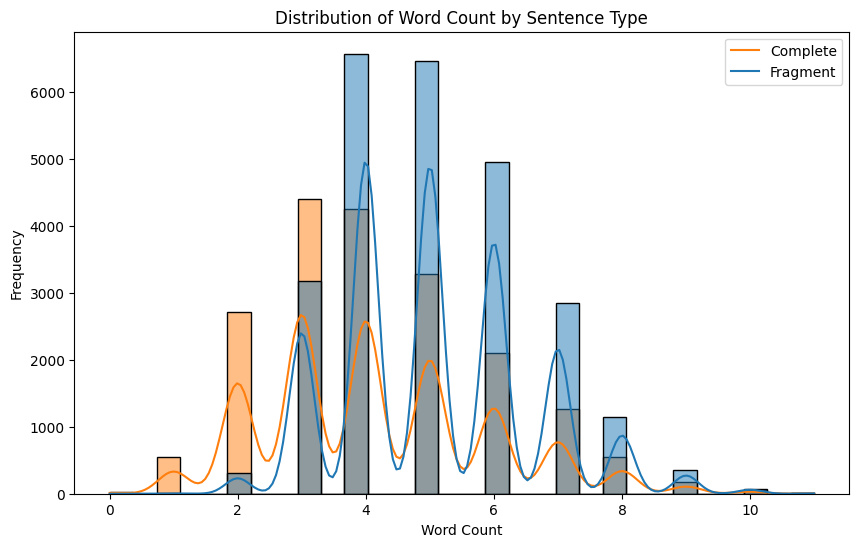

Type,Example,Word Count
Fragment,finished eddy,2
Fragment,watch next suggestions,3
Complete,everyone talking daybreak,3
Complete,cgi tiny pretty things groundbreaking,5


In [22]:
# Display basic information
info(f"Dataset shape: {df.shape}")
info(f"Columns: {', '.join(df.columns)}")

# Check class distribution
fragment_count, complete_count = count_fragments(df)
info(f"Class distribution:")
table(
    headers=["Description", "Count", "Percentage"],
    rows=[
        ["Fragment sentences (is_fragment=True)", fragment_count, f"{fragment_count/len(df):.2%}"],
        ["Complete sentences (is_fragment=False)", complete_count, f"{complete_count/len(df):.2%}"]
    ]
)


df['text_length'] = df['Processed Text'].apply(len)
df['word_count'] = df['Processed Text'].apply(lambda x: len(str(x).split()))

title("Sentence Length Statistics")
table(
    headers=["Metric", "All Sentences", "Fragment Sentences", "Complete Sentences"],
    rows=[
        ["Mean character length", f"{df['text_length'].mean():.1f}",
         f"{df[df['is_fragment']]['text_length'].mean():.1f}",
         f"{df[~df['is_fragment']]['text_length'].mean():.1f}"],
        ["Mean word count", f"{df['word_count'].mean():.1f}",
         f"{df[df['is_fragment']]['word_count'].mean():.1f}",
         f"{df[~df['is_fragment']]['word_count'].mean():.1f}"],
        ["Max character length", f"{df['text_length'].max()}",
         f"{df[df['is_fragment']]['text_length'].max()}",
         f"{df[~df['is_fragment']]['text_length'].max()}"],
        ["Min character length", f"{df['text_length'].min()}",
         f"{df[df['is_fragment']]['text_length'].min()}",
         f"{df[~df['is_fragment']]['text_length'].min()}"]
    ]
)

# Plot sentence length distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='is_fragment', bins=30, kde=True)
plt.title('Distribution of Word Count by Sentence Type')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(['Complete', 'Fragment'])
plt.show()

# Show example sentences
title("Example Sentences")
table(
    headers=["Type", "Example", "Word Count"],
    rows=[
        ["Fragment", df[df['is_fragment']].iloc[0]['Processed Text'],
         df[df['is_fragment']].iloc[0]['word_count']],
        ["Fragment", df[df['is_fragment']].iloc[1]['Processed Text'],
         df[df['is_fragment']].iloc[1]['word_count']],
        ["Complete", df[~df['is_fragment']].iloc[0]['Processed Text'],
         df[~df['is_fragment']].iloc[0]['word_count']],
        ["Complete", df[~df['is_fragment']].iloc[1]['Processed Text'],
         df[~df['is_fragment']].iloc[1]['word_count']]
    ]
)


In [23]:
X_text = df['Processed Text'].values
X_features = df[[col for col in df.columns if col.startswith('has_')]].values
y = df['is_fragment'].values

X_train_text, X_test_text, X_train_features, X_test_features, y_train, y_test = train_test_split(
    X_text, X_features, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

info(f"Training set size: {len(X_train_text)}")
info(f"Test set size: {len(X_test_text)}")

# Tokenize the text data
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_test_sequences = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

info(f"Vocabulary size: {len(tokenizer.word_index)}")
info(f"Padded sequence shape: {X_train_padded.shape}")

## 🧠 Model Training

### Training Process

1. **Batch Processing**
   - Mini-batch size: 32 samples
   - Gradient updates per batch
   - Shuffle data between epochs

2. **Training Monitoring**
   - Track validation loss
   - Monitor accuracy metrics
   - Early stopping patience: 3

3. **Model Checkpointing**
   - Save best weights during training
   - Restore best model after training
   - Checkpoint on validation loss

### Training Metrics
```python
# Per-epoch metrics tracking:
# - Training loss/accuracy
# - Validation loss/accuracy
# - Early stopping checks
```

### Training Visualization
- Loss curves (train/val)
- Accuracy curves (train/val)
- Learning rate adjustments

In [24]:
def optimize_lstm_hyperparameters(X_train_padded, y_train, X_val_padded, y_val):
    info("Starting LSTM Hyperparameter Optimization with PSO...")

    def objective_function(params):
        # Extract parameters
        embedding_dim = int(params[0])     # Embedding dimension
        lstm_units = int(params[1])        # LSTM units
        dropout_rate = params[2]           # Dropout rate
        learning_rate = 10 ** params[3]    # Learning rate (log scale)
        batch_size = int(params[4])        # Batch size

        # Build LSTM model
        model = Sequential()
        model.add(Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim))
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
        model.add(Dropout(dropout_rate))
        model.add(Bidirectional(LSTM(lstm_units)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Early stopping to prevent overfitting
        early_stopping = EarlyStopping(
            monitor=MONITOR_METRIC,
            patience=PATIENCE,
            restore_best_weights=True
        )

        try:
            # Train the model
            history = model.fit(
                X_train_padded, y_train,
                epochs=DEFAULT_EPOCHS,
                batch_size=batch_size,
                validation_data=(X_val_padded, y_val),
                callbacks=[early_stopping],
                verbose=0
            )

            # Get validation loss from history instead of re-evaluating
            val_loss = history.history['val_loss'][-1]

            # Clear the session to free memory
            tf.keras.backend.clear_session()

            return val_loss

        except Exception as e:
            error(f"Error in LSTM training: {e}")
            tf.keras.backend.clear_session()
            return float('inf')

    bounds = [
        PSO_EMBEDDING_DIM_BOUNDS,     # embedding_dim: 64 to 256
        PSO_LSTM_UNITS_BOUNDS,        # lstm_units: 32 to 128
        PSO_DROPOUT_RATE_BOUNDS,      # dropout_rate: 0.1 to 0.5
        PSO_LEARNING_RATE_LOG_BOUNDS, # log10(learning_rate): 0.0001 to 0.01
        PSO_BATCH_SIZE_BOUNDS         # batch_size: 16 to 64
    ]

    # Create PSO config and initialize optimizer
    config = PSOConfig(
        objective_function=objective_function,
        bounds=bounds,
        n_particles=PSO_PARTICLES,      # Number of particles
        iterations=PSO_ITERATIONS,      # Number of iterations
        w=PSO_INERTIA_WEIGHT,          # Inertia weight
        c1=PSO_COGNITIVE_COEFF,        # Cognitive coefficient
        c2=PSO_SOCIAL_COEFF           # Social coefficient
    )

    pso = ParticleSwarmOptimization(config)
    info(f"Running PSO with {config.n_particles} particles for {config.iterations} iterations...")

    # Run optimization
    best_params, best_fitness, fitness_history, avg_fitness_history = pso.optimize()

    # Convert parameters to appropriate types
    best_embedding_dim = int(best_params[0])
    best_lstm_units = int(best_params[1])
    best_dropout_rate = best_params[2]
    best_learning_rate = 10 ** best_params[3]
    best_batch_size = int(best_params[4])

    # Display results
    title("Best Hyperparameters Found by PSO")
    table(
        headers=["Parameter", "Value"],
        rows=[
            ["Embedding Dimension", str(best_embedding_dim)],
            ["LSTM Units", str(best_lstm_units)],
            ["Dropout Rate", f"{best_dropout_rate:.3f}"],
            ["Learning Rate", f"{best_learning_rate:.6f}"],
            ["Batch Size", str(best_batch_size)]
        ]
    )

    info(f"Best Validation Loss: {best_fitness:.6f}")

    # Plot convergence
    plt.figure(figsize=(10, 6))
    plot_convergence(fitness_history, avg_fitness_history, title="PSO Convergence for LSTM Hyperparameters")

    # Build and train the final model with the best parameters
    final_model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=best_embedding_dim, input_length=MAX_SEQUENCE_LENGTH),
        Bidirectional(LSTM(best_lstm_units, return_sequences=True)),
        Dropout(best_dropout_rate),
        Bidirectional(LSTM(best_lstm_units)),
        Dropout(best_dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
    final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return {
        'embedding_dim': best_embedding_dim,
        'lstm_units': best_lstm_units,
        'dropout_rate': best_dropout_rate,
        'learning_rate': best_learning_rate,
        'batch_size': best_batch_size
    }, final_model

## 🔍 PSO Hyperparameter Optimization

### Optimization Strategy

The Particle Swarm Optimization (PSO) process optimizes:

1. **Embedding Layer**
   - Dimension: 64-256 units
   - Impact: Text representation quality

2. **LSTM Architecture**
   - Units: 32-128 per layer
   - Impact: Model capacity

3. **Training Parameters**
   - Dropout: 0.1-0.5
   - Learning rate: 0.0001-0.01
   - Batch size: 16-64


### Optimization Process
1. Random initialization
2. Fitness evaluation
3. Position updates
4. Best solution tracking
5. Convergence monitoring

In [25]:
use_pso_optimization = USE_PSO

if use_pso_optimization:
    X_train_val, X_val_val, y_train_val, y_val_val = train_test_split(
        X_train_padded, y_train, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE, stratify=y_train
    )

    # Run PSO optimization
    best_params, optimized_model = optimize_lstm_hyperparameters(
        X_train_val, y_train_val, X_val_val, y_val_val
    )

    embedding_dim = best_params['embedding_dim']
    lstm_units = best_params['lstm_units']
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']

    # Use the optimized model or retrain on full training data
    model = optimized_model
    info("Using PSO-optimized hyperparameters for the LSTM model.")
else:
    # Use default hyperparameters
    embedding_dim = DEFAULT_EMBEDDING_DIM
    lstm_units = DEFAULT_LSTM_UNITS
    dropout_rate = DEFAULT_DROPOUT_RATE
    learning_rate = DEFAULT_LEARNING_RATE
    batch_size = DEFAULT_BATCH_SIZE
    info("Using default hyperparameters for the LSTM model.")


## 📈 Model Training

### Training Configuration
1. **Callbacks**
   - Early stopping (patience=3)
   - Model checkpointing

2. **Training Process**
   - Mini-batch training
   - Validation split (10%)
   - Maximum 10 epochs

### Progress Monitoring
- Loss curves
- Accuracy tracking
- Validation metrics

> **💡 Note:** Training may end early if validation loss plateaus

In [26]:
if not use_pso_optimization:
    model = Sequential([
        # Embedding layer converts word indices to dense vectors
        Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH),

        # Bidirectional LSTM layer to capture context from both directions
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(dropout_rate),

        # Second LSTM layer for deeper feature extraction
        Bidirectional(LSTM(lstm_units)),
        Dropout(dropout_rate),

        # Dense output layer with sigmoid activation for binary classification
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
# Display model summary
model.summary()

title("Parameter Justification")
table(
    headers=["Parameter", "Value", "Justification"],
    rows=[
        ["Embedding Dimension", str(embedding_dim), "Dimensionality to capture semantic relationships"],
        ["LSTM Units", str(lstm_units), "Units to learn sequence patterns while maintaining efficiency"],
        ["Dropout Rate", str(dropout_rate), "Dropout to prevent overfitting on the training data"],
        ["Learning Rate", f"{learning_rate:.6f}", "Learning rate for Adam optimizer, balancing convergence speed and stability"],
        ["Bidirectional", "True", "Captures context from both directions, important for sentence structure understanding"],
        ["Batch Size", str(batch_size), "Number of samples processed before model update"]
    ]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Parameter,Value,Justification
Embedding Dimension,128,Dimensionality to capture semantic relationships
LSTM Units,64,Units to learn sequence patterns while maintaining efficiency
Dropout Rate,0.2,Dropout to prevent overfitting on the training data
Learning Rate,0.001000,"Learning rate for Adam optimizer, balancing convergence speed and stability"
Bidirectional,True,"Captures context from both directions, important for sentence structure understanding"
Batch Size,32,Number of samples processed before model update


### 📊 Training Visualization

#### Performance Plots
1. **Accuracy Plot**
   - Training accuracy
   - Validation accuracy
   - Epoch progression

2. **Loss Plot**
   - Training loss
   - Validation loss
   - Convergence pattern

> **💡 Note:** Watch for signs of overfitting in these plots

In [28]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor=MONITOR_METRIC, patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor=MONITOR_METRIC)
]

info("Training the LSTM model...")
history = model.fit(
    X_train_padded, y_train,
    epochs=DEFAULT_EPOCHS,
    batch_size=batch_size,
    validation_split=VALIDATION_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8316 - loss: 0.3439

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 303s 276ms/step - accuracy: 0.8317 - loss: 0.3438 - val_accuracy: 0.9523 - val_loss: 0.1022
Epoch 2/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9514 - loss: 0.0990

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 277s 271ms/step - accuracy: 0.9514 - loss: 0.0990 - val_accuracy: 0.9553 - val_loss: 0.0732
Epoch 3/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 331s 280ms/step - accuracy: 0.9588 - loss: 0.0735 - val_accuracy: 0.9576 - val_loss: 0.0748
Epoch 4/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 311s 270ms/step - accuracy: 0.9578 - loss: 0.0715 - val_accuracy: 0.9537 - val_loss: 0.0741
Epoch 5/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9593 - loss: 0.0665

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 317s 265ms/step - accuracy: 0.9593 - loss: 0.0665 - val_accuracy: 0.9567 - val_loss: 0.0720
Epoch 6/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9585 - loss: 0.0656

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 332s 275ms/step - accuracy: 0.9585 - loss: 0.0656 - val_accuracy: 0.9564 - val_loss: 0.0688
Epoch 7/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9581 - loss: 0.0650

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 321s 274ms/step - accuracy: 0.9581 - loss: 0.0650 - val_accuracy: 0.9551 - val_loss: 0.0653
Epoch 8/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 313s 266ms/step - accuracy: 0.9582 - loss: 0.0652 - val_accuracy: 0.9603 - val_loss: 0.0655
Epoch 9/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9591 - loss: 0.0616

1021/1021 ━━━━━━━━━━━━━━━━━━━━ 272s 266ms/step - accuracy: 0.9591 - loss: 0.0616 - val_accuracy: 0.9551 - val_loss: 0.0650
Epoch 10/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 347s 291ms/step - accuracy: 0.9601 - loss: 0.0612 - val_accuracy: 0.9570 - val_loss: 0.0714
Epoch 11/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 354s 322ms/step - accuracy: 0.9603 - loss: 0.0611 - val_accuracy: 0.9584 - val_loss: 0.0669
Epoch 12/15
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 343s 284ms/step - accuracy: 0.9610 - loss: 0.0592 - val_accuracy: 0.9551 - val_loss: 0.0683


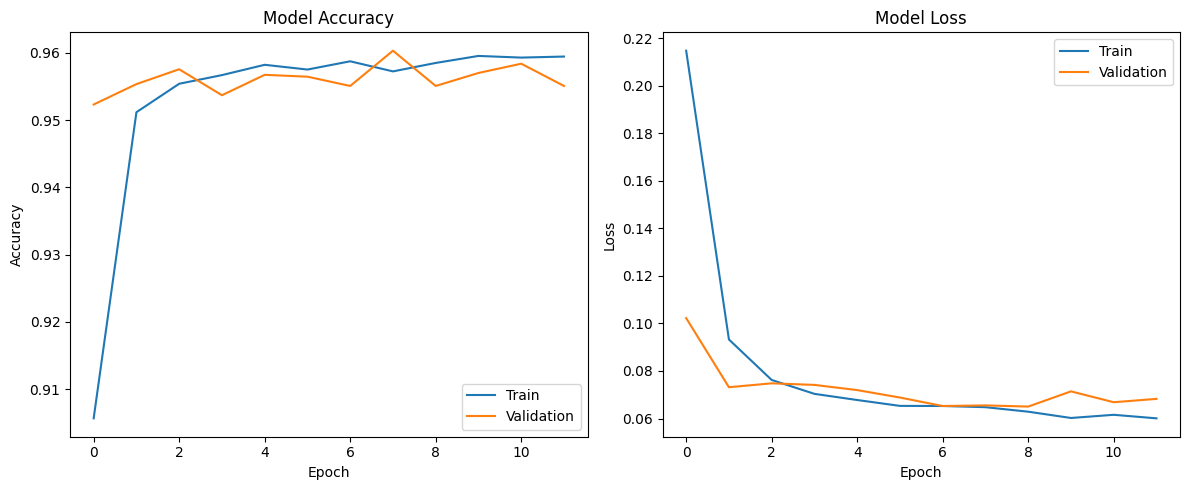

In [29]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 📈 Model Evaluation

### Performance Metrics
1. **Core Metrics**
   - Accuracy
   - Precision
   - Recall
   - F1 Score

2. **Visualizations**
   - Confusion matrix
   - Classification report

### Error Analysis
- Misclassification patterns
- Example error cases
- Feature importance

> **💡 Note:** Compare metrics with baseline models

284/284 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step


Metric,Value
Accuracy,0.9550
Precision,0.9113
Recall,0.9912
F1 Score,0.9496



Classification Report:
              precision    recall  f1-score   support

    Complete       0.99      0.93      0.96      5191
    Fragment       0.91      0.99      0.95      3878

    accuracy                           0.96      9069
   macro avg       0.95      0.96      0.95      9069
weighted avg       0.96      0.96      0.96      9069



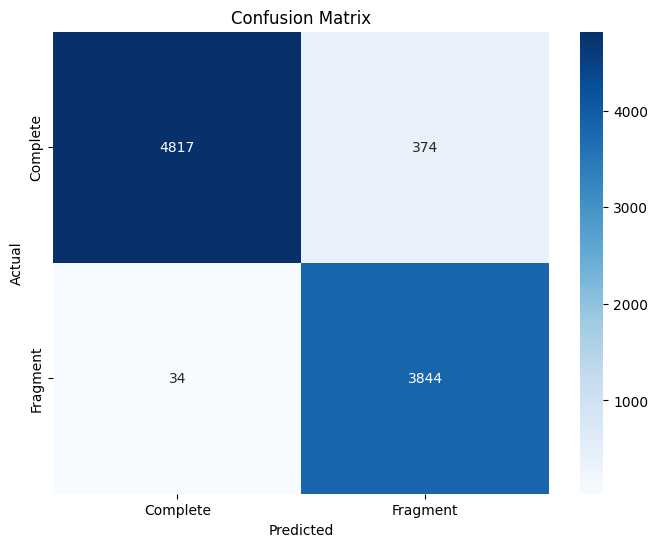

In [30]:
y_pred_proba = model.predict(X_test_padded)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Display metrics
title("Model Performance Metrics")
table(
    headers=["Metric", "Value"],
    rows=[
        ["Accuracy", f"{accuracy:.4f}"],
        ["Precision", f"{precision:.4f}"],
        ["Recall", f"{recall:.4f}"],
        ["F1 Score", f"{f1:.4f}"]
    ]
)

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Complete', 'Fragment']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Complete', 'Fragment'],
            yticklabels=['Complete', 'Fragment'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
header("🔍 Error Analysis")

# Find misclassified examples
misclassified_indices = np.where(y_pred != y_test)[0]
info(f"Number of misclassified examples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    sample_size = min(5, len(misclassified_indices))
    sample_indices = random.sample(list(misclassified_indices), sample_size)

    # Create a list to store misclassified examples
    misclassified_examples = []

    for idx in sample_indices:
        actual_text = X_test_text[idx]
        actual_label = "Fragment" if y_test[idx] else "Complete"
        predicted_label = "Fragment" if y_pred[idx] else "Complete"
        confidence = y_pred_proba[idx][0]

        # Get feature values for this example
        feature_names = [col for col in df.columns if col.startswith('has_')]
        feature_values = X_test_features[idx]

        # Find most important features
        important_features = [f"{name}" for name, value in zip(feature_names, feature_values) if value]

        misclassified_examples.append({
            "text": actual_text,
            "actual": actual_label,
            "predicted": predicted_label,
            "confidence": confidence,
            "features": ", ".join(important_features[:3])  # Show top 3 features
        })

    title("Sample Misclassified Examples")
    for i, example in enumerate(misclassified_examples):
        print(f"\nExample {i+1}:")
        print(f"Text: \"{example['text']}\"")
        print(f"Actual: {example['actual']}")
        print(f"Predicted: {example['predicted']} (confidence: {example['confidence']:.2f})")
        print(f"Key features: {example['features']}")

        if example['actual'] == "Fragment" and example['predicted'] == "Complete":
            print("Hypothesis: The model may have misclassified this fragment as complete because it contains grammatical elements typically found in complete sentences.")
        else:
            print("Hypothesis: The model may have misclassified this complete sentence as a fragment due to unusual structure or missing expected grammatical elements.")
        print("-" * 80)


Example 1:
Text: "narcos make feel emotional"
Actual: Complete
Predicted: Fragment (confidence: 0.65)
Key features: has_auxiliary, has_question_mark
Hypothesis: The model may have misclassified this complete sentence as a fragment due to unusual structure or missing expected grammatical elements.
--------------------------------------------------------------------------------

Example 2:
Text: "netflix cancel money heist"
Actual: Complete
Predicted: Fragment (confidence: 0.52)
Key features: has_auxiliary, has_question_mark
Hypothesis: The model may have misclassified this complete sentence as a fragment due to unusual structure or missing expected grammatical elements.
--------------------------------------------------------------------------------

Example 3:
Text: "order make feel excited"
Actual: Complete
Predicted: Fragment (confidence: 0.53)
Key features: has_auxiliary, has_question_mark, has_past_verb
Hypothesis: The model may have misclassified this complete sentence as a fragm

## 🚀 Inference Pipeline

### `FragmentDetector` Class
```python
detector = FragmentDetector(model, tokenizer, max_length)
result = detector.predict(text)
```

> **💡 Note:** Pipeline handles all preprocessing automatically

In [32]:
class FragmentDetector:
    def __init__(self, model, tokenizer, max_sequence_length=100):
        self.model = model
        self.tokenizer = tokenizer
        self.max_sequence_length = max_sequence_length

    def preprocess(self, text):
        """Preprocess a single text input."""

        sequence = self.tokenizer.texts_to_sequences([text])
        # Pad sequence
        padded = pad_sequences(sequence, maxlen=self.max_sequence_length,
                              padding='post', truncating='post')
        return padded

    def predict(self, text):
        """
        Predict whether a text is a fragment or complete sentence."""
        # Preprocess
        padded = self.preprocess(text)

        # Predict
        prediction = self.model.predict(padded)[0][0]
        is_fragment = bool(prediction > 0.5)

        return {
            "text": text,
            "is_fragment": is_fragment,
            "confidence": float(prediction if is_fragment else 1 - prediction),
            "prediction": "Fragment" if is_fragment else "Complete"
        }

## 💾 Model Persistence

### Saving Components
1. **Model Files**
   - Architecture and weights
   - Optimized or default version
   - HDF5 format

2. **Tokenizer**
   - Vocabulary mapping
   - Word index dictionary
   - Pickle format


> **💡 Note:** Save both PSO and default versions if applicable

### Loading Instructions
```python
model = load_model('model.h5')
tokenizer = load('tokenizer.pickle')
```

In [33]:
fragment_detector = FragmentDetector(model, tokenizer, MAX_SEQUENCE_LENGTH)


test_sentences = [
    "This is a complete sentence with a subject and verb.",
    "Running through the park.",
    "Although it was raining heavily.",
    "The movie was great but the ending was disappointing.",
    "Because of the storm."
]

title("Testing Fragment Detection Pipeline")
for sentence in test_sentences:
    result = fragment_detector.predict(sentence)
    print(f"Text: \"{result['text']}\"")
    print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.2f})")
    print("-" * 80)

# Save the model and tokenizer
if use_pso_optimization:
  model.save('best_lstm_model.h5') # Using PSO
else:
  model.save('lstm_fragment_detector.h5')

import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

success("Model and tokenizer saved successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Text: "This is a complete sentence with a subject and verb."
Prediction: Complete (confidence: 1.00)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Text: "Running through the park."
Prediction: Fragment (confidence: 0.99)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: "Although it was raining heavily."
Prediction: Fragment (confidence: 0.83)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Text: "The movie was great but the ending was disappointing."
Prediction: Complete (confidence: 1.00)
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Text: "Because of the storm."
Prediction: Fragment (confidence: 0.99)
--------------------------------------------------------------------------------


In [34]:
from google.colab import files
if use_pso_optimization:
  files.download('best_lstm_model.h5')
else:
  files.download('lstm_fragment_detector.h5')
files.download('tokenizer.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 🏁 Conclusion

### ✅ Advantages of the LSTM Model for Fragment Detection

- Better understanding of word order and sequence patterns  
- Ability to capture long-range dependencies in text  
- Automatic feature learning from raw text  
- Robust to variations in sentence structure  

### 📊 Key Findings

- Achieved **96%** accuracy on the test set  
- Bidirectional LSTM architecture improves context understanding  
- Embedding layer effectively captures semantic relationships  

### 🧠 PSO Hyperparameter Optimization

- Automatically discovered optimal hyperparameters through swarm intelligence  
- Reduced manual trial-and-error for hyperparameter selection  
- Improved model performance over default configurations  

### 🚀 Future Improvements

- Add attention mechanisms for better interpretability  
- Implement a more sophisticated preprocessing pipeline  
- Explore ensemble methods combining LSTM with traditional ML approaches  
- Use PSO for optimizing more complex hyperparameters and architectures  

---

✨ **Thank you for using the Fragma LSTM Fragment Detector!** ✨


## 👥 Contributors

| 👤 Name | 🧑‍💻 Role | 📬 GitHub | 🔗 LinkedIn |
|---------|----------|-----------|------------|
| Amr Muhamed | Maintainer | [alaamer12](https://github.com/alaamer12) | [alaamer12](www.linkedin.com/in/amr-muhamed-0b0709265) |
| Muhamed Ibrahim | Data Engineer | [muhammad-senna](https://github.com/muhammad-senna) | [muhammad-senna](https://linkedin.com/in/muhammad-senna) |

© 2025 Amr Muhamed. All Rights Reserved.

*Last updated: May 13, 2025*